
# Conflicts and versions 

Conflicts are an essential part of any distributed system. 
Conflicts arise when there are two or more valid versions of the same message.

As we've seen from the previous notebooks, the network can be unreliable: there may be longer delays. But what about faults/conflicts from the clients/message producers? Moreover, a message might have multiple valid versions.  It could be that peers received two versions of the message, both being signed and valid. What version to choose? What to do when an order of the message is important? (e.g. smart contract)



In [1]:
# Initialize the experiment:
import networkx as nx
import p2psimpy as p2p
import warnings
warnings.filterwarnings('ignore')

# Load the previous experiment configurations
exper = p2p.BaseSimulation.load_experiment(expr_dir='crash_gossip')

Locations, topology, peer_services, serv_impl = exper
print(serv_impl)

{'BaseConnectionManager': <class 'p2psimpy.services.connection_manager.BaseConnectionManager'>, 'MessageProducer': <class 'p2psimpy.services.message_producer.MessageProducer'>, 'RandomDowntime': <class 'p2psimpy.services.disruption.RandomDowntime'>, 'RangedPullGossipService': <class 'p2psimpy.services.gossip.RangedPullGossipService'>}


## Client generating conflicting information

Let's assign first adversary nodes, we will assign randomly: 

In [2]:
import random
import string

from p2psimpy import BaseMessage, GossipMessage, MessageProducer, PullGossipService

from p2psimpy.consts import TEMPERED
from p2psimpy.config import Config, Func, Dist
from p2psimpy.services.consensus.majority_neighbors import Transaction

# class Transaction(BaseMessage):
#     pass 

class ConflictMessageProducer(MessageProducer):
    
    def __init__(self, *args, **kwargs):
        kwargs["msg_rate"]= 5
        super().__init__(*args, **kwargs)
        
        self.balance = 100 
        
        
    def _generate_tx(self):        
        msg_phash = ''.join(random.choices(string.ascii_uppercase, k=20))
        diff = random.randint(1, 9)        
        data = {'hash': msg_phash, 'balance': self.balance-diff, 'diff': diff}
        tx = Transaction(self.peer, data)
        
        msg_id = '_'.join((str(self.peer.peer_id), str(self.counter)))
        msg_ttl = self.init_ttl
        return GossipMessage(self.peer, msg_id, tx, msg_ttl, 
            pre_task=self.pre_task, post_task=self.post_task)
    
    def produce_transaction(self):
        # generate new transaction
        msg = self._generate_tx()
        if self.balance - msg.data.data['diff'] < 0:
            return
        
        cons = list(self.peer.connections.keys())
        m_ix = len(cons) // 2
        for p in cons[:m_ix]:
            self.peer.send(p, msg)
            
        # Generate conflicting message as if previous transaction hasn't happened  
        msg = self._generate_tx()
        for p in cons[m_ix:]:
            self.peer.send(p, msg)
        
        self.peer.store('msg_time', str(self.peer.peer_id) +'_' + str(self.counter), self.peer.env.now)
        self.peer.store('msg_data', str(self.peer.peer_id) + '_' + str(self.counter), msg)
        self.balance -= msg.data.data['diff']
        self.counter+=1

def validate_task(msg, peer):
    # time it takes to verify the signature
    crypto_verify = Dist('norm', (1, 0.2)) 
    # time to verify the message data
    msg_verify = Dist("lognorm", (0.49512563, 4.892564, 0.0425785)) 
    
    yield peer.env.timeout(crypto_verify.get() + msg_verify.get())
    if isinstance(msg, Transaction):        
        tx = msg.data
        if tx == TEMPERED or tx['balance'] < 0:
            # You can decide what to do in this case.
            return False
    return True


class MsgConfig(Config):
    pre_task = Func(validate_task)

print(peer_services['client'].service_map)
peer_services['client'].service_map['MessageProducer'] = MsgConfig
serv_impl['MessageProducer'] = ConflictMessageProducer
serv_impl['RangedPullGossipService'] = PullGossipService


{'BaseConnectionManager': None, 'MessageProducer': None}


## Run simulation 

Let's see how adversarial agents together with crashing nodes affect the message dissemination. 

In [3]:
print(serv_impl)
# print(peer_services['client'].service_map.keys())

{'BaseConnectionManager': <class 'p2psimpy.services.connection_manager.BaseConnectionManager'>, 'MessageProducer': <class '__main__.ConflictMessageProducer'>, 'RandomDowntime': <class 'p2psimpy.services.disruption.RandomDowntime'>, 'RangedPullGossipService': <class 'p2psimpy.services.gossip.PullGossipService'>}


In [4]:
# Init Graph
sim = p2p.BaseSimulation(Locations, topology, peer_services, serv_impl)
sim.run(5_200)

## Message analysis

Let's see how this fraction of adverserial nodes affected the network. 


In [17]:
import pandas as pd

def message_data(sim, peer_id, storage_name):
    store = sim.peers[peer_id].storage[storage_name].txs
    for msg_id, tx in store.items():
        client_id, msg_num = msg_id.split('_')
        client_tx = sim.peers[int(client_id)].storage[storage_name].txs[msg_id]
        # yield (int(msg_num), tx.data == client_tx.data)
        yield (int(msg_num), tx.data)
        
def get_gossip_table(sim, storage_name, func):
    return pd.DataFrame({k: dict(func(sim, k, storage_name)) 
                         for k in set(sim.types_peers['peer'])}).sort_index()

    
df = get_gossip_table(sim, 'msg_data', message_data)
df

,1,2,3,4,5,6,7,8,9,10,...,16,17,18,19,20,21,22,23,24,25
1,"Transaction:{'hash': 'VESYQUMZNBXXGWULLRIF', '...","Transaction:{'hash': 'VESYQUMZNBXXGWULLRIF', '...","Transaction:{'hash': 'VESYQUMZNBXXGWULLRIF', '...","Transaction:{'hash': 'VESYQUMZNBXXGWULLRIF', '...","Transaction:{'hash': 'VESYQUMZNBXXGWULLRIF', '...","Transaction:{'hash': 'PZDCDTFIXQUEPVKGRNUM', '...","Transaction:{'hash': 'VESYQUMZNBXXGWULLRIF', '...","Transaction:{'hash': 'VESYQUMZNBXXGWULLRIF', '...","Transaction:{'hash': 'PZDCDTFIXQUEPVKGRNUM', '...","Transaction:{'hash': 'VESYQUMZNBXXGWULLRIF', '...",...,"Transaction:{'hash': 'VESYQUMZNBXXGWULLRIF', '...","Transaction:{'hash': 'PZDCDTFIXQUEPVKGRNUM', '...","Transaction:{'hash': 'VESYQUMZNBXXGWULLRIF', '...","Transaction:{'hash': 'PZDCDTFIXQUEPVKGRNUM', '...","Transaction:{'hash': 'VESYQUMZNBXXGWULLRIF', '...","Transaction:{'hash': 'VESYQUMZNBXXGWULLRIF', '...","Transaction:{'hash': 'VESYQUMZNBXXGWULLRIF', '...","Transaction:{'hash': 'VESYQUMZNBXXGWULLRIF', '...","Transaction:{'hash': 'PZDCDTFIXQUEPVKGRNUM', '...","Transaction:{'hash': 'VESYQUMZNBXXGWULLRIF', '..."
2,"Transaction:{'hash': 'RYGAJDTGTYGTGOLGSWIW', '...","Transaction:{'hash': 'UKDGSNCRNFJFZJVXVBRZ', '...","Transaction:{'hash': 'RYGAJDTGTYGTGOLGSWIW', '...","Transaction:{'hash': 'UKDGSNCRNFJFZJVXVBRZ', '...","Transaction:{'hash': 'RYGAJDTGTYGTGOLGSWIW', '...","Transaction:{'hash': 'RYGAJDTGTYGTGOLGSWIW', '...","Transaction:{'hash': 'RYGAJDTGTYGTGOLGSWIW', '...","Transaction:{'hash': 'UKDGSNCRNFJFZJVXVBRZ', '...","Transaction:{'hash': 'RYGAJDTGTYGTGOLGSWIW', '...","Transaction:{'hash': 'RYGAJDTGTYGTGOLGSWIW', '...",...,"Transaction:{'hash': 'RYGAJDTGTYGTGOLGSWIW', '...","Transaction:{'hash': 'RYGAJDTGTYGTGOLGSWIW', '...","Transaction:{'hash': 'UKDGSNCRNFJFZJVXVBRZ', '...","Transaction:{'hash': 'RYGAJDTGTYGTGOLGSWIW', '...","Transaction:{'hash': 'UKDGSNCRNFJFZJVXVBRZ', '...","Transaction:{'hash': 'UKDGSNCRNFJFZJVXVBRZ', '...","Transaction:{'hash': 'RYGAJDTGTYGTGOLGSWIW', '...","Transaction:{'hash': 'RYGAJDTGTYGTGOLGSWIW', '...","Transaction:{'hash': 'RYGAJDTGTYGTGOLGSWIW', '...","Transaction:{'hash': 'RYGAJDTGTYGTGOLGSWIW', '..."
3,"Transaction:{'hash': 'SOPHARWFJKHPAGWLZSAN', '...","Transaction:{'hash': 'SOPHARWFJKHPAGWLZSAN', '...","Transaction:{'hash': 'ASEHVSSYSOULCNXINCZP', '...","Transaction:{'hash': 'SOPHARWFJKHPAGWLZSAN', '...","Transaction:{'hash': 'SOPHARWFJKHPAGWLZSAN', '...","Transaction:{'hash': 'ASEHVSSYSOULCNXINCZP', '...","Transaction:{'hash': 'SOPHARWFJKHPAGWLZSAN', '...","Transaction:{'hash': 'SOPHARWFJKHPAGWLZSAN', '...","Transaction:{'hash': 'ASEHVSSYSOULCNXINCZP', '...","Transaction:{'hash': 'SOPHARWFJKHPAGWLZSAN', '...",...,"Transaction:{'hash': 'SOPHARWFJKHPAGWLZSAN', '...","Transaction:{'hash': 'SOPHARWFJKHPAGWLZSAN', '...","Transaction:{'hash': 'SOPHARWFJKHPAGWLZSAN', '...","Transaction:{'hash': 'ASEHVSSYSOULCNXINCZP', '...","Transaction:{'hash': 'SOPHARWFJKHPAGWLZSAN', '...","Transaction:{'hash': 'SOPHARWFJKHPAGWLZSAN', '...","Transaction:{'hash': 'SOPHARWFJKHPAGWLZSAN', '...","Transaction:{'hash': 'SOPHARWFJKHPAGWLZSAN', '...","Transaction:{'hash': 'ASEHVSSYSOULCNXINCZP', '...","Transaction:{'hash': 'SOPHARWFJKHPAGWLZSAN', '..."
4,"Transaction:{'hash': 'ASGBRXYPRZNBGFBNZGPZ', '...","Transaction:{'hash': 'XYRJVZDLPMQWBPMEUTSM', '...","Transaction:{'hash': 'ASGBRXYPRZNBGFBNZGPZ', '...","Transaction:{'hash': 'XYRJVZDLPMQWBPMEUTSM', '...","Transaction:{'hash': 'ASGBRXYPRZNBGFBNZGPZ', '...","Transaction:{'hash': 'ASGBRXYPRZNBGFBNZGPZ', '...","Transaction:{'hash': 'ASGBRXYPRZNBGFBNZGPZ', '...","Transaction:{'hash': 'XYRJVZDLPMQWBPMEUTSM', '...","Transaction:{'hash': 'ASGBRXYPRZNBGFBNZGPZ', '...","Transaction:{'hash': 'ASGBRXYPRZNBGFBNZGPZ', '...",...,"Transaction:{'hash': 'ASGBRXYPRZNBGFBNZGPZ', '...","Transaction:{'hash': 'XYRJVZDLPMQWBPMEUTSM', '...","Transaction:{'hash': 'XYRJVZDLPMQWBPMEUTSM', '...","Transaction:{'hash': 'ASGBRXYPRZNBGFBNZGPZ', '...","Transaction:{'hash': 'ASGBRXYPRZNBGFBNZGPZ', '...","Transaction:{'hash'

In [61]:
df[df==False].count()

1      2
2      5
3      7
4      5
5      4
6      7
7      8
8     16
9      2
10     6
11     7
12     6
13    13
14     4
15     6
16     6
17     8
18     2
19     3
20     2
21    14
22     5
23     6
24     8
25     3
dtype: int64

In [72]:
sim.peers[1].storage['msg_data'].txs

{'26_1': GossipMessage:Transaction:{'hash': 'DMSKKQHYPOBPFHRNBICP', 'balance': 91, 'diff': 9},
 '26_2': GossipMessage:Transaction:{'hash': 'XIHQHAQMYPJZNEPVHHAA', 'balance': 82, 'diff': 9},
 '26_4': GossipMessage:Transaction:{'hash': 'HZIQUFVOYTBNSFYZTLEZ', 'balance': 70, 'diff': 7},
 '26_3': GossipMessage:Transaction:{'hash': 'HGRSNJNAPFVUCNWVBBZT', 'balance': 77, 'diff': 9},
 '26_5': GossipMessage:Transaction:{'hash': 'UZYQZEGYOCBUHQKEMDFZ', 'balance': 61, 'diff': 9},
 '26_7': GossipMessage:Transaction:{'hash': 'TJSFQYTFLBRDECYXATRF', 'balance': 50, 'diff': 8},
 '26_6': GossipMessage:Transaction:{'hash': 'TFTCUAMWPUKMLXOYCIWA', 'balance': 58, 'diff': 3},
 '26_9': GossipMessage:Transaction:{'hash': 'YTYXZMNXPSGYTBPZZSBG', 'balance': 37, 'diff': 5},
 '26_8': GossipMessage:Transaction:{'hash': 'WEUWFJKTFSMONAJLGLIA', 'balance': 42, 'diff': 8},
 '26_11': GossipMessage:Transaction:{'hash': 'ILNNXCLTXRWANLILMMNU', 'balance': 29, 'diff': 3},
 '26_14': GossipMessage:Transaction:{'hash': 'UEM

In [74]:
sim.peers[3].storage['msg_data'].txs

{'26_1': GossipMessage:Transaction:{'hash': 'MZVJHWMJEAYXLAXRFROU', 'balance': 96, 'diff': 4},
 '26_2': GossipMessage:Transaction:{'hash': 'XUSJAWZSMYZNWHHIFBWQ', 'balance': 86, 'diff': 5},
 '26_4': GossipMessage:Transaction:{'hash': 'HZIQUFVOYTBNSFYZTLEZ', 'balance': 70, 'diff': 7},
 '26_3': GossipMessage:Transaction:{'hash': 'HGRSNJNAPFVUCNWVBBZT', 'balance': 77, 'diff': 9},
 '26_5': GossipMessage:Transaction:{'hash': 'QIBCUVCKQTXDEKMADPGP', 'balance': 69, 'diff': 1},
 '26_7': GossipMessage:Transaction:{'hash': 'NYOWSSNVYQRADEGANFWK', 'balance': 57, 'diff': 1},
 '26_6': GossipMessage:Transaction:{'hash': 'TFTCUAMWPUKMLXOYCIWA', 'balance': 58, 'diff': 3},
 '26_9': GossipMessage:Transaction:{'hash': 'FIGTRYWYGSJCQPDTJINE', 'balance': 35, 'diff': 7},
 '26_8': GossipMessage:Transaction:{'hash': 'WEUWFJKTFSMONAJLGLIA', 'balance': 42, 'diff': 8},
 '26_11': GossipMessage:Transaction:{'hash': 'ILNNXCLTXRWANLILMMNU', 'balance': 29, 'diff': 3},
 '26_12': GossipMessage:Transaction:{'hash': 'ZOB

Peers see different versions of the same message!
This is an issue as it might violate integrity guarantees. For example, peers might have a different view on the client's balance. 

How to fix this? 
- One way to solve this is to use a (consensus algorithm)[https://en.wikipedia.org/wiki/Consensus_(computer_science)]


# Consensus algorithm


The consensus is a process that allows achieving a consistent view on a value (agreement). 
Some of the peers may fail or be unreliable, so consensus protocols must be fault-tolerant or resilient. The peers must communicate with one another and agree on a single value.

The consensus problem is fundamental in all distributed systems. One approach to generating consensus is for all processes (agents) to agree on a majority value. In this context, a majority requires at least one more than half of the available votes (where each process is given a vote). However, one or more faulty processes may skew the resultant outcome such that consensus may not be reached or reached incorrectly.



#  Exercise 

In this notebook we ask to implement a consensus service and show that all honest peers accept the same value.  
You can assume that an elected leader is never faulty. 
Here are some poissible algorithms you can consider: 
- **Majority Voting**. Fully connected network. Send votes to all nodes. Choose the value based on majority/super-majority. How many rounds/phases do you need? (e.g. hyperledger fabric) (for exercise we assume leader is not malicious)
- **Majority Voting with Neighbours**. Connected network. Send votes to all neighbors. Choose the value based on majority/super-majority of your neighbors. How many rounds/phases you need for full convergence? (e.g. with a trusted group like banks) 
- **Consensus through a lottery**. Send transactions through gossip. Everybody runs some lottery mechanism: that both takes time and chooses one or several nodes. This(these) nodes decide which version of the transaction to pick and send through gossip a decided version of transactions (block). How many rounds of lottery you need for convergence? 

**You can choose any of the above algorithm or propose your own**


As observed in the previous notebooks, convergence is influenced by many factors, such as message ttl, fanout, topology, faults, etc. 

Here with different consensus algorithm, the situation can be different too. 

Majority Voting: Since the value is decided by the votes from all the nodes, it is easier for the peers to get into conclusion. 

Majority Voting with Neighbors: Since the value is decided based on the neighbors and each peer has different set of neighbors, the situation will be more complex than majority voting and thus need more rounds to reach convergence. If the producer sends each half of the group a different version of message, in the end there will be clusters having different values. However if the honest peers are the majority, it can still reach convergence with correct value.

In [3]:
# from p2psimpy.services.consensus.lottery import Consensus
from p2psimpy.services.consensus.majority_neighbors import Consensus
from p2psimpy.services.gossip import GossipService
from p2psimpy.services.message_producer import MessageProducer
from p2psimpy.services.gossip import PullGossipService, RangedPullGossipService
from p2psimpy.services.connection_manager import BaseConnectionManager    

# How to use consensus here?

# Load the previous experiment configurations
my_exper = p2p.BaseSimulation.load_experiment(expr_dir='crash_gossip')

my_locations, my_topology, my_peer_services, my_serv_impl = my_exper


# Change to use lottery Consensus
my_serv_impl['MessageProducer'] = ConflictMessageProducer
my_serv_impl['RangedPullGossipService'] = Consensus
# my_serv_impl['GossipService'] = RangedPullGossipService #?
my_serv_impl.pop('RandomDowntime', None)
my_peer_services['peer'].service_map.pop('RandomDowntime', None)


print(my_peer_services)
print(my_serv_impl)

{'client': PeerType(config=<class 'p2psimpy.config.PeerConfig'>, service_map={'BaseConnectionManager': None, 'MessageProducer': None}), 'peer': PeerType(config=<class 'p2psimpy.config.PeerConfig'>, service_map={'BaseConnectionManager': None, 'RangedPullGossipService': <class 'p2psimpy.config.GossipConfig'>})}
{'BaseConnectionManager': <class 'p2psimpy.services.connection_manager.BaseConnectionManager'>, 'MessageProducer': <class '__main__.ConflictMessageProducer'>, 'RangedPullGossipService': <class 'p2psimpy.services.consensus.majority_neighbors.Consensus'>}


In [4]:
import matplotlib.pyplot as plt
def visualize_peer_client_network(G):
    plt.figure(figsize=(10,10))

    # Draw client/ peer network 

    master_nodes = [n for (n,ty) in \
        nx.get_node_attributes(G,'type').items() if ty == 'peer']
    client_nodes = [n for (n,ty) in \
        nx.get_node_attributes(G,'type').items() if ty == 'client']

    pos = nx.kamada_kawai_layout(G)

    nx.draw_networkx_nodes(G, pos, nodelist=master_nodes, \
        node_color='blue', node_shape='o', node_size=500)
    nx.draw_networkx_nodes(G, pos, nodelist=client_nodes,  \
        node_color='green', node_shape='^', node_size=100, label=1)

    nx.draw_networkx_labels(G, pos, labels={k:k for k in master_nodes}, font_color='w')

    nx.draw_networkx_edges(G, pos, edgelist=G.subgraph(master_nodes).edges(), width=1.5)
    nx.draw_networkx_edges(G, pos, edgelist=G.edges(nbunch=client_nodes),  style='dotted')


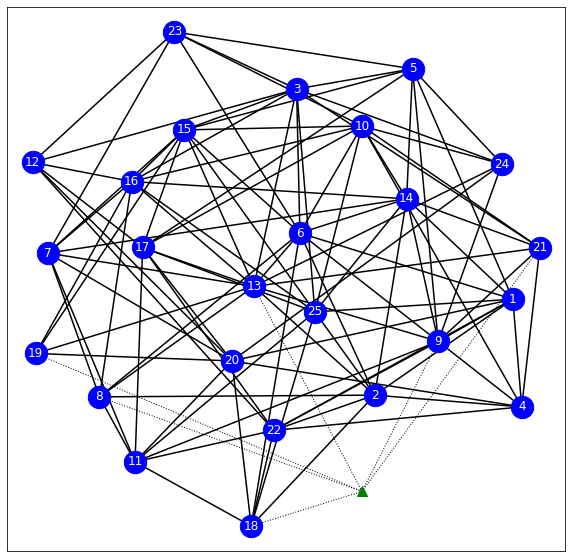

In [5]:
visualize_peer_client_network(my_topology)

In [6]:
my_sim = p2p.BaseSimulation(my_locations, my_topology, my_peer_services, my_serv_impl)
my_sim.run(5_200)

In [7]:
import pandas as pd

def message_data(sim, peer_id, storage_name):
    store = sim.peers[peer_id].storage[storage_name].txs
    for msg_id, tx in store.items():
        client_id, msg_num = msg_id.split('_')
        client_tx = sim.peers[int(client_id)].storage[storage_name].txs[msg_id]
        yield (int(msg_num), tx.data == client_tx.data)
        # yield (int(msg_num), tx.data)
        
def get_gossip_table(sim, storage_name, func):
    return pd.DataFrame({k: dict(func(sim, k, storage_name)) 
                         for k in set(sim.types_peers['peer'])}).sort_index()

    
df = get_gossip_table(my_sim, 'msg_data', message_data)
df

,1,2,3,4,5,6,7,8,9,10,...,16,17,18,19,20,21,22,23,24,25
1,True,False,False,False,False,False,True,True,True,False,...,False,True,False,False,False,False,True,False,False,False
2,True,False,False,False,False,False,True,True,True,False,...,False,False,False,False,False,False,False,False,False,False
3,True,False,False,False,False,False,True,True,True,False,...,False,False,False,False,False,False,True,False,False,False
4,True,False,False,False,False,False,True,True,True,False,...,False,True,False,False,False,False,True,False,False,False
5,True,False,False,False,False,False,True,True,True,False,...,False,True,False,False,False,False,True,False,False,False
6,False,False,False,False,False,False,True,True,True,False,...,False,False,False,False,False,False,True,False,False,False
7,True,False,False,False,False,False,True,True,True,False,...,False,False,False,False,False,False,False,False,False,False
8,False,False,False,False,False,False,True,True,True,False,...,True,False,False,False,False,False,True,False,True,False
9,True,True,False,False,False,False,True,True,True,False,...,False,False,False,False,False,False,True,False,False,False
10,True,False,True,False,False,False,True,True,True,False,...,True,False,False,False,False,False,True,False,False,False


In [8]:
df[df==False].count()

1      3
2     19
3     19
4     21
5     18
6     20
7      0
8      0
9      0
10    21
11    21
12    11
13    15
14    20
15    19
16    17
17    14
18    21
19    21
20    21
21    21
22     4
23    19
24    17
25    21
dtype: int64

In [18]:
print(list(my_topology.neighbors(5)))
print(list(my_topology.neighbors(9)))
print(list(my_topology.neighbors(11)))
print(list(my_topology.neighbors(12)))
print(list(my_topology.neighbors(18)))
print(list(my_topology.neighbors(23)))

[1, 3, 9, 14, 15, 17, 23, 24]
[1, 4, 5, 6, 11, 13, 14, 21, 22, 24, 26]
[7, 8, 9, 17, 18, 20, 22, 25]
[3, 16, 17, 20, 22, 23]
[2, 6, 11, 20, 22, 25, 26]
[3, 5, 6, 7, 10, 12]
